# Tim Datapidia
* Danendra Athallariq Harya Putra
* Rifqi Syahri Ramadani
* Sulthan Alam

# Data preparation

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
# data contain slang words
slang = pd.read_csv('/content/drive/MyDrive/DataVidia/lexicon.csv', error_bad_lines = False)
slang_dict ={}
for i in range(len(slang)):
  slang_dict[slang.iloc[i]['slang']] =  slang.iloc[i]['formal']

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DataVidia/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DataVidia/test.csv")
train.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


# Data Cleaning

In [ ]:
#Library for data cleaning
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Membuat fungsi untuk menghapus angka
def remove_numbers(text):
  result=re.sub(r'\d+', '', text)
  return result

In [ ]:
#Membuat fungsi untuk menghapus spasi berlebih
def remove_whitespace(text):
  return " ".join(text.split())

In [ ]:
#Menghapus emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
def _normalize_contractions_text(text):
  contractions = slang_dict
  new_token_list = []
  token_list = text.split()
  for word_pos in range(len(token_list)):
    word = token_list[word_pos]
    first_upper = False
    if word[0].isupper():
      first_upper = True
    if word.lower() in contractions:
      replacement = contractions[word.lower()]
      if first_upper:
        replacement = replacement[0].upper()+replacement[1:]
      replacement_tokens = replacement.split()
      if len(replacement_tokens)>1:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
        new_token_list.append(replacement_tokens[1])
        #print(new_token_list)
      else:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
    else:
      new_token_list.append(word)
      #print(new_token_list)
  sentence = " ".join(new_token_list).strip(" ")
  return(sentence)

In [ ]:
s = _normalize_contractions_text("hari ini nyenengin banget deh")
print(s)

hari ini menyenangkan banget deh


In [ ]:
def lemmatize(kalimat):
  tokens = word_tokenize(kalimat)
  listStopword =  set(stopwords.words('indonesian'))
 
  removed = []
  for t in tokens:
      if t not in listStopword:
          removed.append(t)
  cleaned = " ".join(removed)
  return cleaned

s = "aku pergi ke pasar di hari minggu bersama ayah"
s1 = lemmatize(s)
print(s1)

pergi pasar minggu ayah


In [ ]:
def clean(kalimat):
  cleaned = remove_numbers(kalimat)
  cleaned = remove_whitespace(cleaned)
  cleaned = deEmojify(cleaned)
  cleaned = _normalize_contractions_text(cleaned)
  cleaned = lemmatize(cleaned)
  return cleaned

s = clean("aku pergi ke pasar di hari minggu bersama ayah sangat nyenengin karna yg")
print(s)

pergi pasar minggu ayah menyenangkan


## Cleaning data before inputting it to model

In [ ]:
train_cleaned = train.copy()
train_cleaned['review_cleaned'] = train['review_text'].apply(clean)
train_cleaned.head()

,review_id,review_text,category,review_cleaned
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,"Penginapannya rapi , bersih , suasana tenang ,..."
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,"wifi kamar , tersedia heater kopi/teh dispense..."
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,"Lantai kamar mandi kotor , bau , sarang nyamuk..."
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,"Wc jorok.. Kasur dibersihkan , , handuk diganti ,"
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,bocor


In [ ]:
from sklearn.model_selection import train_test_split

#splitting data for validation and training
X = train_cleaned['review_cleaned']
y = train_cleaned['category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify = y, random_state=42)

In [ ]:
all_train_sentences = X.values.tolist()

train_sentences =X_train.values.tolist()
train_labels = y_train.values.tolist()

val_sentences =X_val.values.tolist()
val_labels = y_val.values.tolist()

In [ ]:
embedding_dim = 200#khusus word2vec harus 300
#max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
#initialize tokenizer based on all training sentences(before split)
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(all_train_sentences)

#make indexing for each word
word_index = tokenizer.word_index
vocab_size=len(word_index)

#tokenize with padding X_train
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type)
train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

#tokenize with padding X_val
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding=padding_type, truncating=trunc_type)
val_padded = np.array(val_padded)
val_labels = np.array(val_labels)


# Kalo gk mau cleaning data

In [ ]:
from sklearn.model_selection import train_test_split

#splitting data for validation and training
X = train['review_text']
y = train['category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify = y, random_state=42)

In [ ]:
all_train_sentences = X.values.tolist()

train_sentences =X_train.values.tolist()
train_labels = y_train.values.tolist()

val_sentences =X_val.values.tolist()
val_labels = y_val.values.tolist()

In [ ]:
embedding_dim = 200#khusus word2vec ikutin mau programnya aje
#max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
#initialize tokenizer based on all training sentences(before split)
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(all_train_sentences)

#make indexing for each word
word_index = tokenizer.word_index
vocab_size=len(word_index)

#tokenize with padding X_train
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type)
train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

#tokenize with padding X_val
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding=padding_type, truncating=trunc_type)
val_padded = np.array(val_padded)
val_labels = np.array(val_labels)

# EDA

In [ ]:
sns.set_palette(palette="Blues_r")

## Wordcloud

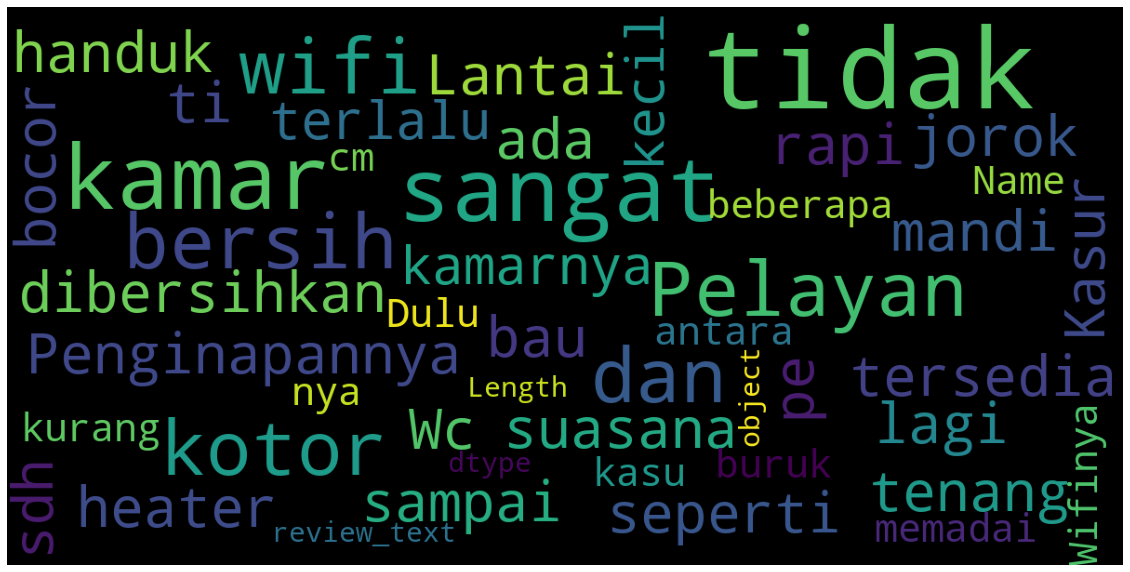

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(train["review_text"])

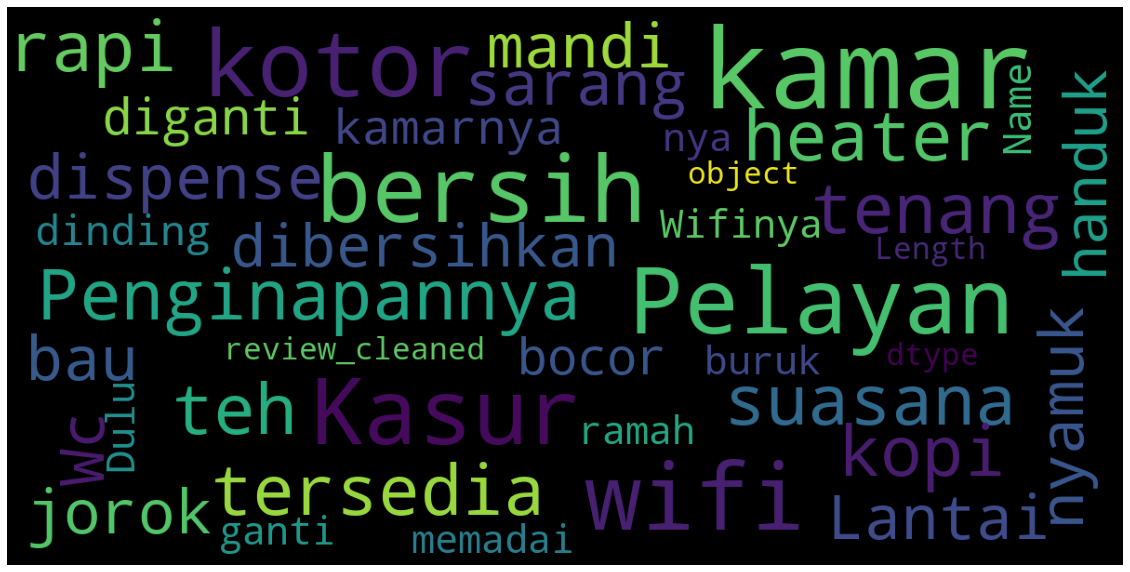

In [ ]:
show_wordcloud(train_cleaned["review_cleaned"])

## Histogram Banyak Kata

In [ ]:
import seaborn as sns
train_cleaned["nb_words"] = train_cleaned["review_text"].apply(lambda x: len(x.split(" ")))
train_cleaned["nb_words_cleaned"] = train_cleaned["review_cleaned"].apply(lambda x: len(x.split(" ")))

fig, axs = plt.subplots(ncols=2,figsize=(20, 5))
sns.histplot(x = "nb_words" , data = train_cleaned,ax = axs[0])
axs[0].set_title(f'Distribusi Banyak Kata dari Review Asli')

sns.histplot(x = "nb_words_cleaned", data=train_cleaned,ax = axs[1])
axs[1].set_title(f'Distribusi Banyak Kata dari Review yang Sudah Dibersihkan')

# Set common labels
fig.text(0.5, 0.04, 'Banyak Kata', ha='center', va='center')
fig.text(0.06, 0.5, 'Jumlah', ha='center', va='center', rotation='vertical')

NameError: ignored

## Countplot Kategori


Text(0.5, 1.0, 'Jumlah Kategori pada Review')

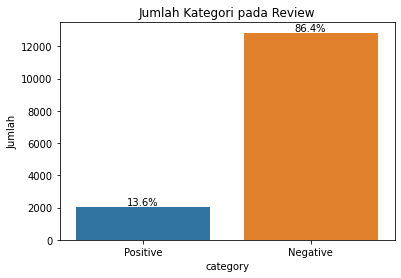

In [ ]:
train_cleaned_copy = train.copy()
train_cleaned_copy['category'] = train_cleaned_copy['category'].apply(lambda x:"Positive" if x==1 else "Negative")
ax = sns.countplot(x = "category",data=train_cleaned_copy)

for p in ax.patches:
  ax.annotate('{:.1f}%'.format(p.get_height()/len(train)*100), (p.get_x()+0.3, p.get_height()+100))

ax.set_ylabel("Jumlah")
ax.set_title("Jumlah Kategori pada Review")

In [ ]:
train_cleaned['category'].value_counts().values.tolist()

[12839, 2017]

# Modelling

## Conv then LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=2)

print("Training Complete")

## Multi Layer LSTM





In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()

num_epochs = 50

history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=2,validation_data=(val_padded, val_labels))

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2455200   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,964,769
Trainable params: 2,964,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
372/372 - 25s - loss: 0.2430 - tp: 1109.0000 - fp: 302.0000 - tn: 12537.0000 - fn: 908.0000 - accur

## Word2vec

In [ ]:
from gensim.models import Word2Vec
w2vmodel = Word2Vec.load("/content/drive/MyDrive/DataVidia/idwiki_word2vec_200_new_lower.model")
embedding_index = {}
for idx, key in enumerate(w2vmodel.wv.vocab):
    embedding_index[key] = w2vmodel.wv[key]

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
from tensorflow import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
model = tf.keras.Sequential([                     
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()

num_epochs = 50

history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=2,validation_data=(val_padded, val_labels))

print("Training Complete")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         2800000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 3,309,569
Trainable params: 509,569
Non-trainable params: 2,800,000
_________________________________________________________________
Epoch 1/50
372/372 - 19s - loss: 0.2070 - tp: 973.0000 - fp: 251.0000 - tn: 10020.0000 - fn: 640.0000 - 

# Visualisasi per Epochs

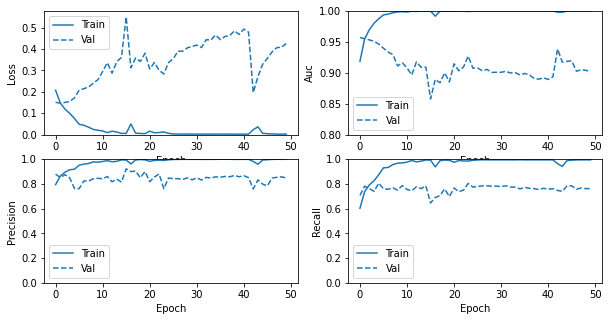

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(10, 5))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

# Prediksi

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/DataVidia/test.csv")
testing_sentences = test['review_text'].values.tolist()
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type)

In [ ]:
testing_padded = np.array(testing_padded)
predicted = model.predict_classes(testing_padded).tolist()
category = []
for p in predicted:
  category.append(p[0])
category[:5]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0, 0, 0, 0, 1]

In [ ]:
index = test['review_id'].values.tolist()
d = {"review_id":index,"category":category}
df = pd.DataFrame(data=d)
df.head()

,review_id,category
0,7302180ac7160f04a405d8aa7bd6beb8,0
1,3184c670e170f565c7522eb76a320ba1,0
2,e33abf6bb5d5a9a77c339043b1725dc8,0
3,061d388950340070a6ac03fabc9027b0,0
4,e62d87c348674b6c06856964f3ab16b8,1


In [ ]:
compression_opts = dict(method='zip',archive_name='last_try.csv') 
df.to_csv('last_try.zip', index=False,compression=compression_opts)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('last_try.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>